## Time Series Forecasting Tutorial ##

#### Using ML (XGboost) to forecast energy consumption #

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [80]:
df = pd.read_csv('PJME_hourly.csv')

In [81]:
df = df.set_index('Datetime')

In [82]:
pd.concat([df.head(),df.tail()])

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0


In [83]:
df.index = pd.to_datetime(df.index)

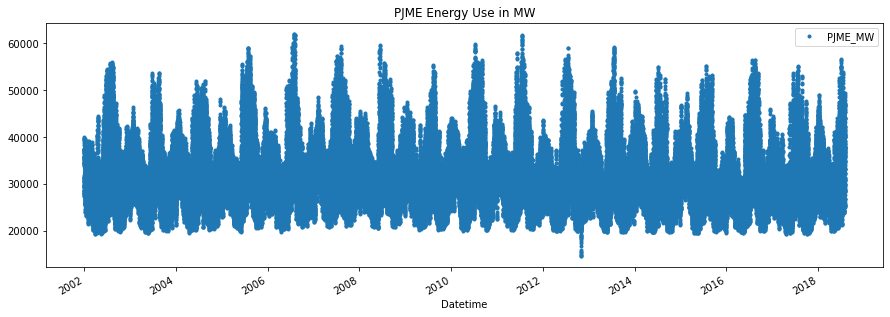

In [84]:
df.plot(style = '.', figsize = (15,5), color = color_pal[0], title = 'PJME Energy Use in MW')
plt.show()

### Outlier Analysis 

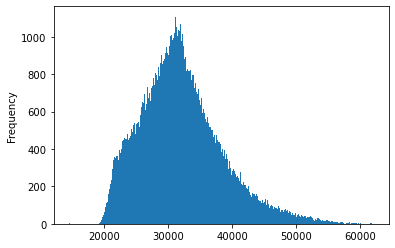

In [85]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)
plt.show()

<AxesSubplot:xlabel='Datetime'>

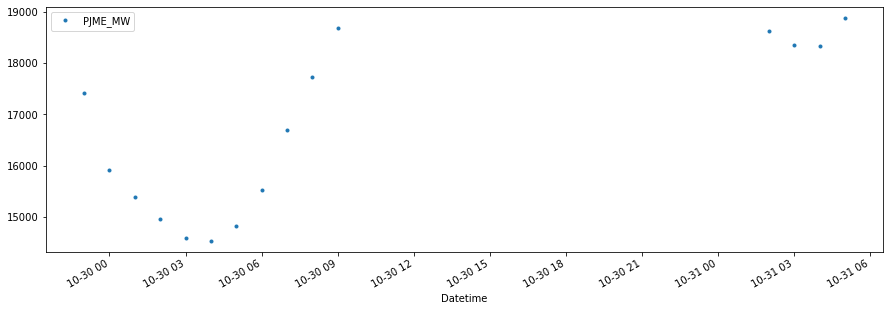

In [86]:
df.query('PJME_MW < 19000').plot(figsize =(15,5), style = '.')

In [87]:
df = df.query('PJME_MW > 19000').copy()

## Train / Test Split ##

<bound method Axes.legend of <AxesSubplot:title={'center':'Data Train/Test Split'}, xlabel='Datetime'>>

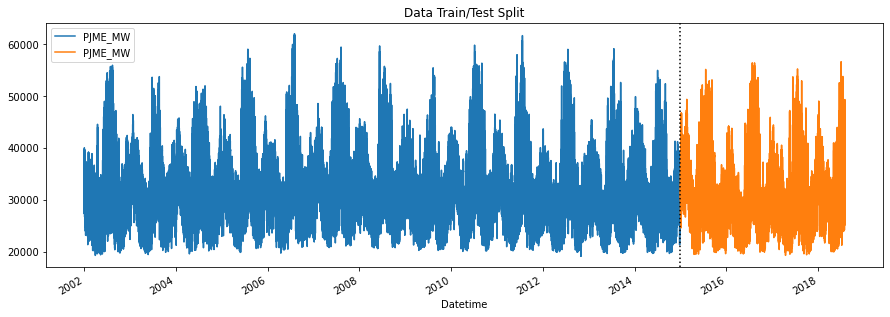

In [88]:
df_train = df.loc[df.index  < '01-01-2015']
df_test = df.loc[df.index  >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))

df_train.plot(ax = ax , label = 'Training Set' , title = 'Data Train/Test Split')
df_test.plot(ax = ax, label = ' Test Set')
ax.axvline('01-01-2015', color = 'black', ls = 'dotted')
ax.legend

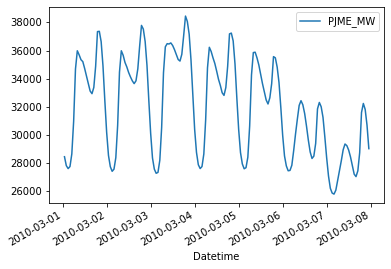

In [89]:
df.loc[(df.index > '03-01-2010') & (df.index < '03-08-2010')].plot()
plt.show()

### Time Series Cross Validation

In [90]:
from sklearn.model_selection import TimeSeriesSplit

In [91]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24 * 365 * 1, gap = 24)
### sort dataset index , otherwise cross val will not work

df = df.sort_index()

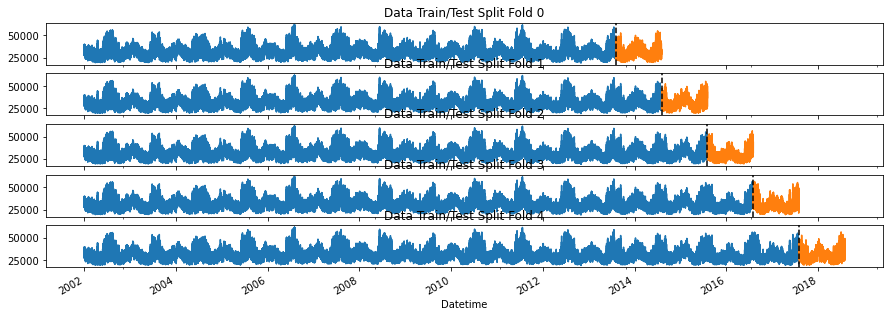

In [92]:
fig, axs = plt.subplots(5,1, figsize = (15,5),
                            sharex = True)

fold = 0


for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax = axs[fold],
                         label = 'Training Set',
                         title = f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax = axs[fold],
                         label = 'Test Set'
                         )
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1
plt.show()

### Forecasting Horizon Explained

## Feature Creation 

In [93]:
def create_features(df):
    """
    Create Time Series Features
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214


## Lag features

In [94]:
def add_lags(df_1):
    target_map = df['PJME_MW'].to_dict()
    df_1['lag1'] = (df_1.index - pd.Timedelta('364 days')).map(target_map)
    df_1['lag2'] = (df_1.index - pd.Timedelta('728 days')).map(target_map)
    df_1['lag3'] = (df_1.index - pd.Timedelta('1092 days')).map(target_map)
    return df_1

In [107]:
df = add_lags(df)

### Visualize Feature/ Target  Realtionship

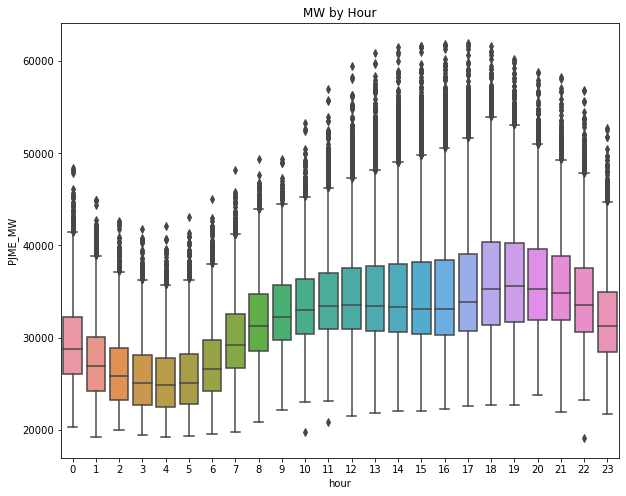

In [96]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

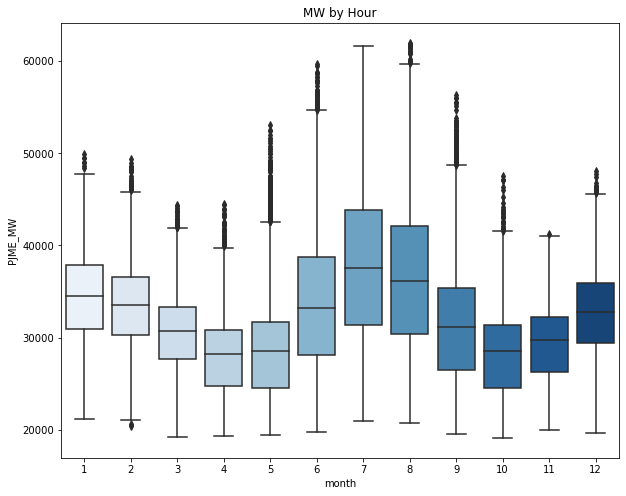

In [97]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette = 'Blues')
ax.set_title('MW by Hour')
plt.show()

### CREATE MODEL ###

In [98]:
train = create_features(df_train)
test = create_features(df_test)

Features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']

Target = 'PJME_MW'

In [99]:
X_train  = train[Features]
y_train = train[Target] 

X_test  = test[Features]
y_test = test[Target]

In [100]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)],verbose = 100)

[0]	validation_0-rmse:6405.28445	validation_1-rmse:6480.13094
[100]	validation_0-rmse:3909.87734	validation_1-rmse:4311.87826
[200]	validation_0-rmse:3243.25262	validation_1-rmse:3865.72569
[300]	validation_0-rmse:2995.46635	validation_1-rmse:3745.78494
[400]	validation_0-rmse:2827.84032	validation_1-rmse:3742.79426
[409]	validation_0-rmse:2814.29025	validation_1-rmse:3744.17271


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

In [101]:
Feature_imp = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_
                          , columns = ['importance'])

<AxesSubplot:title={'center':' Feature Importance'}>

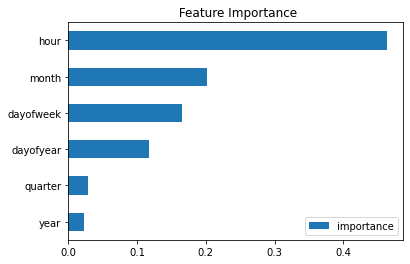

In [102]:
Feature_imp.sort_values('importance').plot(kind = 'barh', title = ' Feature Importance')

### Forecast on Test

In [103]:
test['prediction'] = reg.predict(X_test)

In [104]:
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

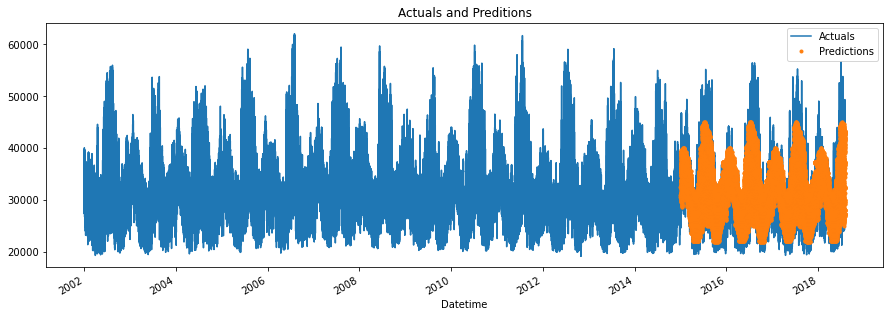

In [105]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax= ax, style = '.')
plt.legend(['Actuals', 'Predictions'])
ax.set_title('Actuals and Preditions')
plt.show()

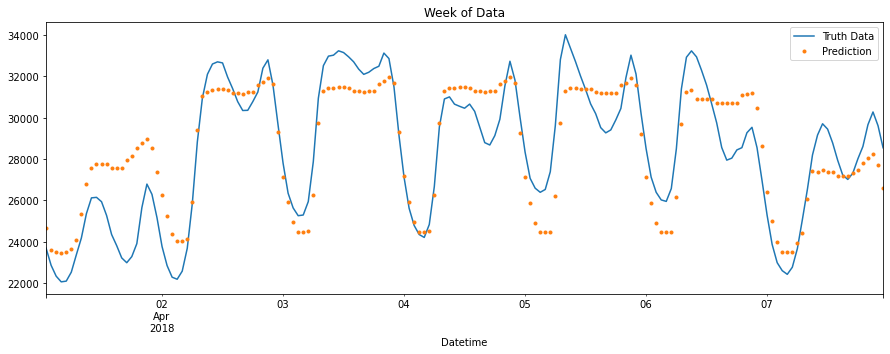

In [106]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
.plot(figsize = (15,5), title = 'Week of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
.plot(style = '.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()